In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

In [2]:
plt.style.use('notebook')

In [3]:
t = Table(fits.getdata('../data/pal5_ls_lite.fits'))

In [10]:
a2ebv = [3.995, 3.214, 2.165, 1.592, 1.211, 1.064]
bands = ['u', 'g', 'r', 'i', 'z', 'Y']

g = 22.5 - 2.5*np.log10(t['flux_g']) - t['ebv']*a2ebv[1]
r = 22.5 - 2.5*np.log10(t['flux_r']) - t['ebv']*a2ebv[2]

points = np.array([g-r, g]).T

/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


In [5]:
ceq = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, frame='icrs')

In [6]:
cgal = ceq.galactic

In [20]:
cpal = ceq.transform_to(gc.Pal5)

In [22]:
wangle = 180*u.deg

### Define CMD mask

In [7]:
iso = Table.read('../data/mist_11.5_-1.30.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [11]:
# distance moduli are different for the leading and trailing arms
cmd_masks = []
for dist in [19,23]:
    distance_app = dist*u.kpc
    dm = 5*np.log10((distance_app.to(u.pc)).value)-5

    # main sequence + rgb
    i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
    i_g = iso['DECam_g']+dm
    i_r = iso['DECam_r']+dm

    i_left = i_gr - 0.12*(i_g/28)**5
    i_right = i_gr + 0.12*(i_g/28)**5

    poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
    ind = (poly[:,1]<23.7) & (poly[:,1]>20)
    poly_main = poly[ind]
    path_main = mpl.path.Path(poly_main)
    
    cmd_masks += [path_main.contains_points(points)]

### Combine individual arm masks

In [12]:
ra0 = 229.022083*u.deg
dec0 = -0.111389*u.deg

In [13]:
ra_masks = [[ceq.ra<ra0], [ceq.ra>=ra0]]

In [37]:
mask = ((cmd_masks[0] & ra_masks[0]) | (cmd_masks[1] & ra_masks[1]))[0]

In [38]:
np.sum(mask), np.size(mask)

(244719, 23942933)

In [39]:
np.shape(mask)

(23942933,)

In [40]:
for x in [mask, cpal.phi1, cpal.phi2]:
    print(np.size(x))

23942933
23942933
23942933


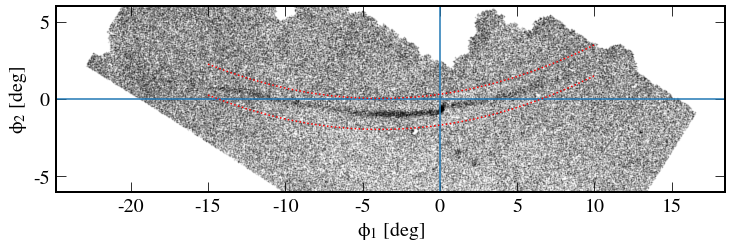

In [103]:
fig, ax = plt.subplots(1,1,figsize=(12,10))

plt.plot(cpal.phi1.wrap_at(wangle)[mask], cpal.phi2[mask], 'k.', ms=1, alpha=0.12)

plt.axhline(0)
plt.axvline(0)

# plt.axhline(1, ls=':', color='orange')
# plt.axhline(-1.5, ls=':', color='orange')

p = [0.018,0.14,-0.7]
poly_track_coarse = np.poly1d(p)
x_grid = np.linspace(-15,10,20)
y = poly_track_coarse(x_grid)

plt.plot(x_grid, y+1, 'r:')
plt.plot(x_grid, y-1, 'r:')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.ylim(-6,6)

plt.gca().set_aspect('equal')

## Running median => track

In [117]:
delta_phi2 = 1
phi2_mask = ((cpal.phi2.deg<poly_track_coarse(cpal.phi1.wrap_at(wangle).deg ) + delta_phi2) & 
             (cpal.phi2.deg>poly_track_coarse(cpal.phi1.wrap_at(wangle).deg) - delta_phi2))

In [126]:
bin_spacing = 1*u.deg
bin_width = 1*u.deg

be0 = np.arange(-15, 7, bin_spacing.to(u.deg).value)*u.deg
be1 = be0 + bin_width

bc = 0.5 * (be0 + be1)

In [127]:
N = np.size(bc)
phi2_med = np.zeros(N) * u.deg

In [128]:
for i in range(N):
    ind = (cpal.phi1.wrap_at(wangle)>be0[i]) & (cpal.phi1.wrap_at(wangle)<=be1[i])
    phi2_med[i] = np.median(cpal.phi2[phi2_mask & mask & ind].deg)*u.deg

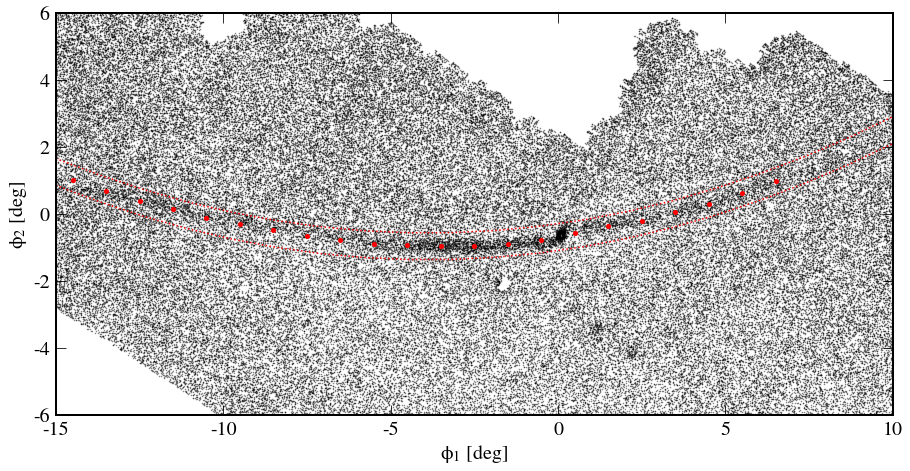

In [142]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

plt.plot(cpal.phi1.wrap_at(wangle)[mask], cpal.phi2[mask], 'k.', ms=1, alpha=0.5)

plt.plot(bc, phi2_med, 'ro', ms=4)
plt.plot(x_grid, y+0.4, 'r:')
plt.plot(x_grid, y-0.4, 'r:')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.ylim(-6,6)
plt.xlim(-15,10)

plt.gca().set_aspect('equal')